In [1]:
cd("D:/Academics/Harvard/2020 Fall/Analytics Edge/Assignments/HW5")

In [2]:
### Importation of relevant packages
using JuMP
using Gurobi
using CSV
using DataFrames

In [3]:
### Data importation for the whole problem
centers = convert(Matrix,CSV.File("centers.csv"; header=false) |> DataFrame!);
stations = convert(Matrix,CSV.File("stations.csv"; header=false) |> DataFrame!);
landfills = convert(Matrix,CSV.File("landfills.csv"; header=false) |> DataFrame!);
q = convert(Matrix,CSV.File("q.csv"; header=false) |> DataFrame!);

In [4]:
### Definition of number of centers, transfer stations, landfills
n1 = size(centers)[1];
s1 = size(stations)[1];
m1 = size(landfills)[1];

In [5]:
### Definition of distance matrices
# The data give us coordinates of centers, landfills and transfer stations.
# We need to use them to compute the distances between each pair of locations
# This is done below in Julia
# Alternatively, you could have computed distances in Excel, saved your file as 
# a new .csv file, and imported this new data file in Julia.
d1 = sqrt.(
    (centers[:,1] * ones(1,m1) - ones(n1,1) * transpose(landfills[:,1])) .^2 +
    (centers[:,2] * ones(1,m1) - ones(n1,1) * transpose(landfills[:,2])) .^2);

d2 = sqrt.(
    (centers[:,1] * ones(1,s1) - ones(n1,1) * transpose(stations[:,1])) .^2 +
    (centers[:,2] * ones(1,s1) - ones(n1,1) * transpose(stations[:,2])) .^2);

d3 = sqrt.(
    (stations[:,1] * ones(1,m1) - ones(s1,1) * transpose(landfills[:,1])) .^2 +
    (stations[:,2] * ones(1,m1) - ones(s1,1) * transpose(landfills[:,2])) .^2);

In [6]:
# Part A
# a) The objective is to minimize the total transportation cost
# Transportation cost is assumed to be a linear function of distance travelled and 
# the weight of waste. It is also assumed that the unit transport cost is constant.
# Thus (1) the objective function minimizes the sum of the product of the distance 
# between each pairs of locations times their respective amount of waste.

# Constraints: 
# (2) All the waste generated in each center is disposed
# (3) If landfill j is not built, the amount of waste shipped from each centers to
# landfill j must equals 0. If landfill j is built, the amount of waste shipped from 
# each center to landfill j must be no more than the amount collected at the center.
# Thus M equals to q-i
# (4) Total number of landfills built must be no more than 5
# (5) The amount of waste shipped between each pair of locations must not be negative
# (6) z-j must be either 1 or 0, indicating a landfilll is built or unbuilt.

In [7]:
# b) Resize q
q = q[:,:1];

# Implement the linear optimization model
mod = Model(Gurobi.Optimizer);
set_optimizer_attribute(mod, "MIPGap", 0.0001);
@variable(mod, x[1:n1, 1:m1] >= 0);
@variable(mod, z[1:m1], Bin);
@objective(mod, Min,
    sum(d1[i, j] * x[i, j] for i in 1:n1, j in 1:m1)
    );
@constraint(mod, [i in 1:n1], sum(x[i,j] for j in 1:m1) == q[i]);
@constraint(mod, [i in 1:n1, j in 1:m1], x[i,j] <= q[i]*z[j]);
@constraint(mod, sum(z[j] for j in 1:m1) <= 5);
optimize!(mod)

Academic license - for non-commercial use only - expires 2021-01-19
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 801 rows, 765 columns and 2265 nonzeros
Model fingerprint: 0x57d04f5a
Variable types: 750 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [2e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+03]
Presolve time: 0.02s
Presolved: 801 rows, 765 columns, 2265 nonzeros
Variable types: 750 continuous, 15 integer (15 binary)

Root relaxation: objective 8.404875e+05, 136 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    840487.52400 840487.524  0.00%     -    0s

Explored 0 nodes (136 simplex iterations) in 0.07 seconds
Thread coun

In [8]:
# Total distance travelled byt the waste
obj_opt = objective_value(mod)

840487.5240012796

In [9]:
# Landfills index
z_opt = value.(z)
index = findall(x->x==1, z_opt)

5-element Array{Int64,1}:
  3
  4
  7
 13
 14

In [ ]:
# Optimization result: Landfills built at index 3,4,7,13,14
# Total distance travelled by the waste is 840487.52 miles

In [29]:
# c) Vary the number of landfills from 5 to 10
# Define a base model
function base_model()
    model = Model(Gurobi.Optimizer);
    set_optimizer_attribute(model, "MIPGap", 0.0001);
    @variable(model, x[1:n1, 1:m1] >= 0);
    @variable(model, z[1:m1], Bin);
    @objective(model, Min,
        sum(d1[i, j] * x[i, j] for i in 1:n1, j in 1:m1)
        );
    @constraint(model, [i in 1:n1], sum(x[i,j] for j in 1:m1) == q[i]);
    @constraint(model, [i in 1:n1, j in 1:m1], x[i,j] <= q[i]*z[j]);
    return model
end

# Initialize an array and a dict for storing model results
landfill_set = Dict()
total_distance = []

# Iterate landfill number constraint from 5 to 10
for c = 5:10  
    m = base_model()
    @constraint(m, sum(m[:z][j] for j in 1:m1) <= c);
    optimize!(m)
    
    opt_d = objective_value(m)
    push!(total_distance, opt_d)
    
    z = value.(m[:z])
    location = findall(x->x==1, z)
    push!(landfill_set, c => location)
end

Academic license - for non-commercial use only - expires 2021-01-19
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 801 rows, 765 columns and 2265 nonzeros
Model fingerprint: 0x57d04f5a
Variable types: 750 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [2e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+03]
Presolve time: 0.00s
Presolved: 801 rows, 765 columns, 2265 nonzeros
Variable types: 750 continuous, 15 integer (15 binary)

Root relaxation: objective 8.404875e+05, 136 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    840487.52400 840487.524  0.00%     -    0s

Explored 0 nodes (136 simplex iterations) in 0.02 seconds
Thread coun

In [11]:
# i) Reporting the total distance traveled by the waste
total_distance

6-element Array{Any,1}:
 840487.5240012796
 784973.1017063984
 751731.74144438
 723810.9577610842
 707215.1395992909
 699121.1277070486

In [12]:
using Plots

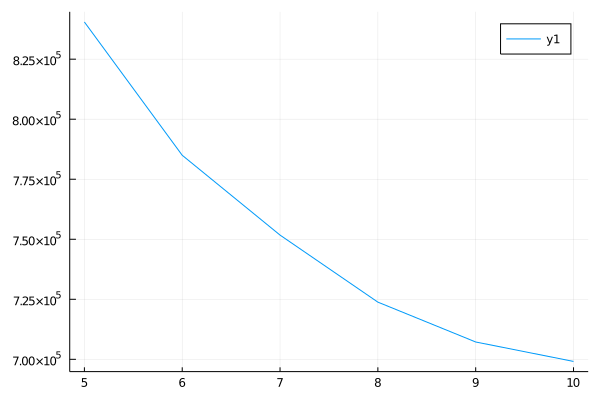

In [13]:
# Plotting the total distance traveled by the waste as a function of the number of 
# landfills. Observation: as the number of landfills increases, the total distance 
# decreases. But the efficiency of deceasing total distance drops as the number of 
# landfills gets larger.

plot(5:10, total_distance)

In [14]:
# ii) Reporting the set of landfills built each time as a function of the number of 
# landfills. Observation: As the number of landfills increases, the new set of 
# landfills chosen includes the previous set

sort(collect(landfill_set))

6-element Array{Pair{Any,Any},1}:
  5 => [3, 4, 7, 13, 14]
  6 => [3, 4, 7, 11, 13, 14]
  7 => [3, 4, 6, 7, 11, 13, 14]
  8 => [3, 4, 5, 6, 7, 11, 13, 14]
  9 => [2, 3, 4, 5, 6, 7, 11, 14, 15]
 10 => [2, 3, 4, 5, 6, 7, 11, 12, 14, 15]

In [15]:
### Part B
# d) Constraints
# (10) If landfill j is not built, the amount of waste shipped from each centers to 
# landfill j must equals 0. If landfill j is built, the amount of waste shipped from 
# a center to landfill j must be no more than the amount collected at the center.
# Thus the value of M-1 is q-i

# (11) If station k is not built, the amount of waste shipped from each center to 
# station k must equals 0. If station k is built, the amount of waste shipped from 
# a center to station k must be no more than the amount collected at the center.
# Thus the value of M-2 is also q-i

# (12) If landfill j is not built, the amount of waste shipped from each station 
# to landfill j must equals 0. If landfill j is built, the amount of waste shipped 
# from a station to landfill j must be no more than the capacity of that station
# Thus the value of M-3 is 2000

# (13) Total number of landfills must be no more than 5
# (14) For each transfer, the amount of waste cannot exceed the capacity of a station
# (15) The amount of waste shipped between each pair of locations must not be negative
# (16) y-k must be either 1 or 0, indicating a landfilll is built or unbuilt.
# (17) z-j must be either 1 or 0, indicating a landfilll is built or unbuilt.

In [16]:
# e) The objective is to minimize the sum of total station building cost plus total 
# transport cost. 

# Total station building cost equals to the number of stations built times unit 
# building cost(10000).

# Total transport cost can be broken down into three types:
# direct transport from centers to landfills,with uncompacted unit transport cost at 1;
# transport from centers to stations, wtih uncompacted unit transport cost at 1;
# and transport from stations to landfills, with compacted unit transport cost at 0.5.
# Thus the objective function is

$$\min \sum_{k=1}^{50} y_k \times 10000 + \sum_{i=1}^{50}\sum_{j=1}^{15} d1_{ij} x1_{ij} + \sum_{i=1}^{50}\sum_{k=1}^{50} d2_{ik} x2_{ik} + \sum_{k=1}^{50}\sum_{j=1}^{15} d3_{kj} x3_{kj} \times 0.5$$

In [17]:
# f) Constraint (8) make sure that all the waste generated in each center is disposed.
# The total amount of waste shipped from each center includesthe amount shipped 
# directly to landfills and the amount shipped to stations.
# Thus the constraint equation is

$$\sum_{j=1}^{15} x1_{ij} + \sum_{k=1}^{50} x2_{ik} = q_i,  \forall i = 1,\cdots,50$$

In [18]:
# g) Constraint (9) the flow balance
# no waste is left at any transfer station

$$\sum_{i=1}^{50} x2_{ik} = \sum_{j=1}^{15} x3_{kj},  \forall k = 1,\cdots,50$$

In [20]:
# h) Implement the model
mod2 = Model(Gurobi.Optimizer);
set_optimizer_attribute(mod2, "MIPGap", 0.0001);
@variable(mod2, x1[1:n1, 1:m1] >= 0);
@variable(mod2, x2[1:n1, 1:s1] >= 0);
@variable(mod2, x3[1:s1, 1:m1] >= 0);
@variable(mod2, y[1:s1], Bin);
@variable(mod2, z[1:m1], Bin);

# Objective function
@objective(mod2, Min,
    10000 * sum(y[k] for k in 1:s1) + # building station cost
    1 * sum(d1[i, j] * x1[i, j] for i in 1:n1, j in 1:m1) +  # directly to landfills
    1 * sum(d2[i, k] * x2[i, k] for i in 1:n1, k in 1:s1) +  # to station
    0.5 * sum(d3[k, j] * x3[k, j] for k in 1:s1, j in 1:m1)  # station to landfills
    );

# Waste collection constraint
@constraint(mod2, [i in 1:n1], 
    sum(x1[i,j] for j in 1:m1) + sum(x2[i,k] for k in 1:s1) == q[i]
    );

# Flow balance constraint
@constraint(mod2, [k in 1:s1], 
    sum(x2[i,k] for i in 1:n1) == sum(x3[k,j] for j in 1:m1)
    );

# Upperbound of different transport legs
@constraint(mod2, [i in 1:n1, j in 1:m1], x1[i,j] <= q[i]*z[j]);
@constraint(mod2, [i in 1:n1, k in 1:s1], x2[i,k] <= q[i]*y[k]);
@constraint(mod2, [k in 1:s1, j in 1:m1], x3[k,j] <= 2000*z[j]);

# Transfer station capacity constraint
@constraint(mod2, [k in 1:s1], sum(x2[i,k] for i in 1:n1) <= 2000);

# The number of landfills constraint
@constraint(mod2, sum(z[j] for j in 1:m1) <= 5);

optimize!(mod2)

Academic license - for non-commercial use only - expires 2021-01-19
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 4151 rows, 4065 columns and 17015 nonzeros
Model fingerprint: 0x8283a6a7
Variable types: 4000 continuous, 65 integer (65 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+00, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+03]
Found heuristic solution: objective 3979977.1191
Presolve time: 0.02s
Presolved: 4151 rows, 4065 columns, 17065 nonzeros
Variable types: 4000 continuous, 65 integer (65 binary)

Root relaxation: objective 7.651519e+05, 529 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 765151.944    0   36 3979977.12 765151.944  80.8%     -    0s
H    0     0 

In [21]:
# Reporting the indexes of stations built
# The number of stations built is 9
y_opt2 = value.(y)
index_y = findall(x->x==1, y_opt2)

9-element Array{Int64,1}:
  4
 12
 21
 23
 30
 31
 32
 39
 45

In [22]:
# Reporting the index of landfills built
z_opt2 = value.(z)
index_z = findall(x->x==1, z_opt2)

5-element Array{Int64,1}:
  3
  4
  7
 13
 14

In [23]:
# The fraction of waste that gets compacted is 35.12%
waste_total = sum(q[i] for i in 1:n1)
compacted = sum(value.(x2[i,k]) for i in 1:n1, k in 1:s1)
compacted_fraction = compacted / waste_total

0.35115546797472375

In [24]:
# The total distance traveled is 876496.76 mile*ton
# This is higher than the earlier solution(840487.52)
dis_total = sum(d1[i, j] * value.(x1[i, j]) for i in 1:n1, j in 1:m1) +
    sum(d2[i, k] * value.(x2[i, k]) for i in 1:n1, k in 1:s1) +
    sum(d3[k, j] * value.(x3[k, j]) for k in 1:s1, j in 1:m1)

876496.7565920389

In [25]:
# The transportation cost is $718642.75
# Since in the earlier solution all wast is uncompacted, 
# the unit transport cost is constant (1 per mile per ton).
# The transport cost of the earlier solution equals to 840487.52 * 1
# The new solution is lower than the earlier solution(840487.52)
trans_cost = sum(d1[i, j] * value.(x1[i, j]) for i in 1:n1, j in 1:m1) +
    sum(d2[i, k] * value.(x2[i, k]) for i in 1:n1, k in 1:s1) +
    0.5 * sum(d3[k, j] * value.(x3[k, j]) for k in 1:s1, j in 1:m1)

718642.7541913454

In [26]:
# Reporting the total datily cost
# The total cost(808642.75) is lower than the earlier solution(840487.52)
obj_opt2 = objective_value(mod2)

808642.7541913455